### Parameter Prediction

#### Data preprocessing

In [3]:
import pandas as pd
import numpy as np

In [4]:
# Hacemos el match entre las caracteristicas de cada instancia y sus parametros obtenidos con paramILS

df_solomon = pd.read_csv("solomon_features.csv")
f = open("solomonExecution/best_params_10_1000.csv","r")
params = pd.DataFrame(columns= f.readline().strip().split(",")[2:8]) #Obtenemos nombres de parámetros
for line in f:
    line = line.strip().split(",")
    params.loc[len(params.index)] = [line[2] + ".txt"] + [float(i) for i in line[3:8]]
f.close()

df_solomon = df_solomon.merge(params,on=["instance"])

df_homberger = pd.read_csv("Homberger_features.csv")
f2 = open("hombergerExecution/best_params_10_1000.csv","r")
params_h = pd.DataFrame(columns= f2.readline().strip().split(",")[2:8]) #Obtenemos nombres de parámetros
for line in f2:
    line = line.strip().split(",")
    params_h.loc[len(params_h.index)] = [line[2] + ".txt"] + [float(i) for i in line[3:8]]
f2.close()

df_homberger = df_homberger.merge(params_h,on=["instance"])

df_with_params = pd.concat([df_solomon,df_homberger],axis=0).reset_index(drop=True)
df_with_params

,instance,client_number,distance_centroid_depot,average_distance_to_depot,cv_distance_to_depot,average_distance_to_centroid,cv_distance_to_centroid,ratio_mean_client_demand_capacity,ratio_cv_client_demand_capacity,average_clients_per_vehicle,...,outlier_ratio,avg_clients_per_cluster,cv_clients_per_cluster,intra_cluster_distance,inter_cluster_distance,gs,nc,ne,ps,xi
0,R106.txt,100.0,0.0156,0.2444,0.3725,0.2441,0.3709,0.0729,0.3027,4.0,...,0.3900,0.0417,0.0177,0.0360,0.0471,40.0,0.1,0.2,25.0,0.6
1,R208.txt,100.0,0.0156,0.2444,0.3725,0.2441,0.3709,0.0146,0.0605,4.0,...,0.3900,0.0417,0.0177,0.0360,0.0471,100.0,0.6,0.4,15.0,0.6
2,C207.txt,100.0,0.0243,0.2331,0.3041,0.2324,0.3004,0.0259,0.0818,4.0,...,0.2000,0.0625,0.0068,0.0425,0.0533,10.0,0.1,0.4,25.0,0.6
3,RC206.txt,100.0,0.0436,0.2596,0.3019,0.2565,0.3009,0.0172,0.0544,4.0,...,0.1800,0.0333,0.0086,0.0299,0.0324,20.0,0.2,0.4,25.0,0.6
4,R110.txt,100.0,0.0156,0.2444,0.3725,0.2441,0.3709,0.0729,0.3027,4.0,...,0.3900,0.0417,0.0177,0.0360,0.0471,10.0,0.2,0.4,45.0,0.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
351,R1_6_2.txt,600.0,0.0099,0.2605,0.0921,0.2603,0.0923,0.0895,0.2511,4.0,...,0.1500,0.0057,0.0032,0.0102,0.0176,10.0,0.6,0.8,5.0,0.4
352,C2_4_3.txt,400.0,0.0430,0.2403,0.1369,0.2355,0.1433,0.0270,0.0620,4.0,...,0.1700,0.0088,0.0044,0.0109,0.0164,10.0,0.2,0.4,15.0,0.6
353,C1_6_3.txt,600.0,0.0184,0.2565,0.0932,0.2555,0.0943,0.0918,0.2172,4.0,...,0.0333,0.0169,0.0004,0.0134,0.0295,10.0,0.8,0.4,5.0,0.2
354,C1_10_2.txt,1000.0,0.0381,0.2868,0.0523,0.2842,0.0529,0.0897,0.2218,4.0,...,0.0430,0.0110,0.0004,0.0096,0.0208,10.0,0.8,0.4,5.0,0.2


In [5]:
from sklearn import preprocessing

X = df_with_params.drop(["instance"],axis=1)
Y = X[X.columns[-5:]]
X = X[X.columns[:-5]]

Y = Y[["gs","nc","ne","ps","xi"]]

#Normalizamos X
scaler_X = preprocessing.MinMaxScaler(feature_range=(0,1))
X_normalized = scaler_X.fit_transform(X)
X_normalized = pd.DataFrame(X_normalized,columns=X.columns)

#Normalizamos Y
scaler_Y = preprocessing.MinMaxScaler(feature_range=(0,1)) 
Y_normalized = scaler_Y.fit_transform(Y)
Y_normalized = pd.DataFrame(Y_normalized,columns=Y.columns)

In [6]:
Y_normalized

,gs,nc,ne,ps,xi
0,0.333333,0.000000,0.142857,0.50,0.714286
1,1.000000,0.714286,0.428571,0.25,0.714286
2,0.000000,0.000000,0.428571,0.50,0.714286
3,0.111111,0.142857,0.428571,0.50,0.714286
4,0.000000,0.142857,0.428571,1.00,0.428571
...,...,...,...,...,...
351,0.000000,0.714286,1.000000,0.00,0.428571
352,0.000000,0.142857,0.428571,0.25,0.714286
353,0.000000,1.000000,0.428571,0.00,0.142857
354,0.000000,1.000000,0.428571,0.00,0.142857


#### Building a simple neural network

In [7]:
import numpy as np
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils import plot_model

2024-01-04 15:13:32.728870: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-04 15:13:33.237019: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-04 15:13:33.237097: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-04 15:13:33.335729: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-04 15:13:33.515693: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-04 15:13:33.519219: I tensorflow/core/platform/cpu_feature_guard.cc:1

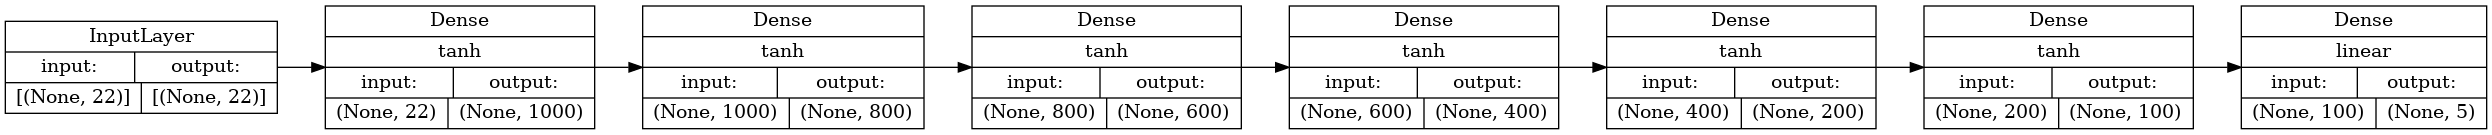

In [26]:
model = Sequential()
model.add(Dense(1000, input_shape=(22,), activation='tanh'))
model.add(Dense(800, activation='tanh'))
model.add(Dense(600, activation='tanh'))
model.add(Dense(400, activation='tanh'))
model.add(Dense(200, activation='tanh'))
model.add(Dense(100, activation='tanh'))
model.add(Dense(5, activation='linear'))

optimizer = AdamW(learning_rate=0.002)
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mean_squared_error'])

# Train the model with early stopping
#history = model.fit(X_normalized, Y_normalized, epochs=2000, batch_size=100, verbose=True)


plot_model(model, to_file='model_plot.png', show_shapes=True, rankdir="LR", show_layer_names=False, show_layer_activations=True)

#### Testing predictions

In [48]:
# Predictions on the whole dataset
preds = model.predict(X_normalized)
preds

12/12 [==============================] - 0s 5ms/step


array([[ 0.33360967, -0.05833722,  0.16264671,  0.5282153 ,  0.7944316 ],
       [ 0.93972427,  0.7260981 ,  0.47327685,  0.2598556 ,  0.6740249 ],
       [-0.02295879, -0.02588369,  0.45876625,  0.50418663,  0.7255725 ],
       ...,
       [ 0.01414493,  0.93031853,  0.48893502,  0.01804175,  0.17944792],
       [ 0.00772207,  1.017519  ,  0.4663692 ,  0.00231916,  0.12509522],
       [ 0.00414756,  0.42351174,  0.6994507 ,  0.00851384,  0.42321345]],
      dtype=float32)

In [49]:
predicted_params = pd.DataFrame(scaler_Y.inverse_transform(preds),columns=Y.columns)
predicted_params = pd.concat([df_with_params["instance"],predicted_params],axis=1)
predicted_params["gs"] = predicted_params["gs"].astype(int)
predicted_params["ps"] = predicted_params["ps"].astype(int)
predicted_params = predicted_params.round(2)
predicted_params

,instance,gs,nc,ne,ps,xi
0,R106.txt,40,0.06,0.21,26,0.66
1,R208.txt,94,0.61,0.43,15,0.57
2,C207.txt,7,0.08,0.42,25,0.61
3,RC206.txt,17,0.17,0.40,26,0.61
4,R110.txt,14,0.16,0.37,45,0.44
...,...,...,...,...,...,...
351,R1_6_2.txt,7,0.53,0.78,5,0.42
352,C2_4_3.txt,9,0.19,0.44,14,0.58
353,C1_6_3.txt,11,0.75,0.44,5,0.23
354,C1_10_2.txt,10,0.81,0.43,5,0.19


In [51]:
predicted_params.columns = ["instance","gs_p","nc_p","ne_p","ps_p","xi_p"]
df_params_comparison = pd.merge(df_with_params[["instance","gs","nc","ne","ps","xi"]],predicted_params,on="instance")
df_params_comparison

,instance,gs,nc,ne,ps,xi,gs_p,nc_p,ne_p,ps_p,xi_p
0,R106.txt,40.0,0.1,0.2,25.0,0.6,40,0.06,0.21,26,0.66
1,R208.txt,100.0,0.6,0.4,15.0,0.6,94,0.61,0.43,15,0.57
2,C207.txt,10.0,0.1,0.4,25.0,0.6,7,0.08,0.42,25,0.61
3,RC206.txt,20.0,0.2,0.4,25.0,0.6,17,0.17,0.40,26,0.61
4,R110.txt,10.0,0.2,0.4,45.0,0.4,14,0.16,0.37,45,0.44
...,...,...,...,...,...,...,...,...,...,...,...
351,R1_6_2.txt,10.0,0.6,0.8,5.0,0.4,7,0.53,0.78,5,0.42
352,C2_4_3.txt,10.0,0.2,0.4,15.0,0.6,9,0.19,0.44,14,0.58
353,C1_6_3.txt,10.0,0.8,0.4,5.0,0.2,11,0.75,0.44,5,0.23
354,C1_10_2.txt,10.0,0.8,0.4,5.0,0.2,10,0.81,0.43,5,0.19


In [57]:
feature = "xi"
error_df = abs(df_params_comparison[feature] - df_params_comparison[feature+"_p"])/abs(df_params_comparison[feature+"_p"])
error_df.mean()

0.06195694441377276

#### Using K-Fold Crossvalidation

In [8]:

# Convert X_normalized and Y_normalized to numpy arrays if they are DataFrames
X_normalized = X_normalized.values if isinstance(X_normalized, pd.DataFrame) else X_normalized
Y_normalized = Y_normalized.values if isinstance(Y_normalized, pd.DataFrame) else Y_normalized

# Define the number of folds
n_splits = 4
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize lists to store results
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Initialize early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=500, restore_best_weights=True)

# Loop over the folds
i = 0
for train_index, val_index in kf.split(X_normalized):
    print("Training model number " + str(i))
    X_train, X_val = X_normalized[train_index], X_normalized[val_index]
    Y_train, Y_val = Y_normalized[train_index], Y_normalized[val_index]

    model = Sequential()
    model.add(Dense(1000, input_shape=(22,), activation='tanh'))
    model.add(Dense(800, activation='tanh'))
    model.add(Dense(600, activation='tanh'))
    model.add(Dense(400, activation='tanh'))
    model.add(Dense(200, activation='tanh'))
    model.add(Dense(200, activation='tanh'))
    model.add(Dense(200, activation='tanh'))
    model.add(Dense(200, activation='tanh'))
    model.add(Dense(200, activation='tanh'))
    model.add(Dense(100, activation='tanh'))
    model.add(Dense(50, activation='tanh'))
    model.add(Dense(5, activation='linear'))

    optimizer = AdamW(learning_rate=0.002)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mean_squared_error'])

    # Train the model with early stopping
    history = model.fit(X_train, Y_train, epochs=1000, batch_size=100, verbose=False, 
                        validation_data=(X_val, Y_val), callbacks=[early_stopping])

    # Evaluate the model on the training set
    train_loss, train_accuracy = model.evaluate(X_train, Y_train)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Evaluate the model on the validation set
    val_loss, val_accuracy = model.evaluate(X_val, Y_val)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print("Train Loss: " + str(train_loss) + " Validation Loss: " + str(val_loss))
    i += 1

# Calculate and print the average results over all folds
avg_train_loss = np.mean(train_losses)
avg_train_accuracy = np.mean(train_accuracies)
avg_val_loss = np.mean(val_losses)
avg_val_accuracy = np.mean(val_accuracies)

print(f"Avg Training Loss: {avg_train_loss}")
print(f"Avg Validation Loss: {avg_val_loss}")


Training model number 0


2024-01-04 15:13:39.491694: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-04 15:13:39.492534: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


3/3 [==============================] - 0s 5ms/step - loss: 0.0619 - mean_squared_error: 0.0619
Train Loss: 0.06718049943447113 Validation Loss: 0.06187387928366661
Training model number 1
3/3 [==============================] - 0s 4ms/step - loss: 0.0720 - mean_squared_error: 0.0720
Train Loss: 0.06694459170103073 Validation Loss: 0.07202375680208206
Training model number 2
3/3 [==============================] - 0s 5ms/step - loss: 0.0723 - mean_squared_error: 0.0723
Train Loss: 0.06683115661144257 Validation Loss: 0.0723358541727066
Training model number 3
3/3 [==============================] - 0s 5ms/step - loss: 0.0725 - mean_squared_error: 0.0725
Train Loss: 0.06745271384716034 Validation Loss: 0.07245570421218872
Avg Training Loss: 0.06710224039852619
Avg Validation Loss: 0.069672298617661


Mejor hasta ahora: 0.07

In [9]:
# Predictions on the whole dataset
preds = model.predict(X_normalized)
preds

12/12 [==============================] - 0s 6ms/step


array([[ 0.0418799 ,  0.19555373,  0.42373735,  0.38714302,  0.6082601 ],
       [ 0.04506279,  0.20444646,  0.42152902,  0.38704473,  0.60180384],
       [ 0.02363082,  0.17099637,  0.43159592,  0.38382572,  0.64362115],
       ...,
       [ 0.04985033,  0.53332275,  0.7197311 ,  0.13150534,  0.40456587],
       [ 0.02636294,  0.50414526,  0.7534048 ,  0.06750326,  0.45871693],
       [ 0.01311543,  0.44436142,  0.69504803, -0.00117868,  0.48084062]],
      dtype=float32)

In [10]:
predicted_params = pd.DataFrame(scaler_Y.inverse_transform(preds),columns=Y.columns)
predicted_params = pd.concat([df_with_params["instance"],predicted_params],axis=1)
predicted_params["gs"] = predicted_params["gs"].astype(int)
predicted_params["ps"] = predicted_params["ps"].astype(int)
predicted_params = predicted_params.round(2)
predicted_params

,instance,gs,nc,ne,ps,xi
0,R106.txt,13,0.24,0.40,20,0.53
1,R208.txt,14,0.24,0.40,20,0.52
2,C207.txt,12,0.22,0.40,20,0.55
3,RC206.txt,13,0.24,0.40,20,0.53
4,R110.txt,14,0.24,0.40,20,0.52
...,...,...,...,...,...,...
351,R1_6_2.txt,10,0.41,0.65,6,0.44
352,C2_4_3.txt,15,0.34,0.38,15,0.40
353,C1_6_3.txt,14,0.47,0.60,10,0.38
354,C1_10_2.txt,12,0.45,0.63,7,0.42


In [12]:
predicted_params.to_csv("NeuralNetwork_predicted_parameters.csv",index=False)

In [93]:
predicted_params.columns = ["instance","gs_p","nc_p","ne_p","ps_p","xi_p"]
df_params_comparison = pd.merge(df_with_params[["instance","gs","nc","ne","ps","xi"]],predicted_params,on="instance")
df_params_comparison

,instance,gs,nc,ne,ps,xi,gs_p,nc_p,ne_p,ps_p,xi_p
0,R106.txt,40.0,0.1,0.2,25.0,0.6,20,0.42,0.31,24,0.53
1,R208.txt,100.0,0.6,0.4,15.0,0.6,37,0.70,0.48,23,0.65
2,C207.txt,10.0,0.1,0.4,25.0,0.6,7,0.12,0.35,24,0.48
3,RC206.txt,20.0,0.2,0.4,25.0,0.6,10,0.17,0.24,26,0.46
4,R110.txt,10.0,0.2,0.4,45.0,0.4,27,0.40,0.28,32,0.56
...,...,...,...,...,...,...,...,...,...,...,...
351,R1_6_2.txt,10.0,0.6,0.8,5.0,0.4,10,0.46,0.75,4,0.40
352,C2_4_3.txt,10.0,0.2,0.4,15.0,0.6,16,0.24,0.29,11,0.60
353,C1_6_3.txt,10.0,0.8,0.4,5.0,0.2,16,0.58,0.63,5,0.35
354,C1_10_2.txt,10.0,0.8,0.4,5.0,0.2,12,0.77,0.58,4,0.29


In [101]:
feature = "ne"
error_df = abs(df_params_comparison[feature] - df_params_comparison[feature+"_p"])/abs(df_params_comparison[feature+"_p"]+0.00000001)
error_df.mean()

0.2661023594321224

### Parameter prediction using KNN

In [18]:
import pandas as pd
import numpy as np

In [19]:
# Hacemos el match entre las caracteristicas de cada instancia y sus parametros obtenidos con paramILS

df_solomon = pd.read_csv("solomon_features.csv")
f = open("solomonExecution/best_params_10_1000.csv","r")
params = pd.DataFrame(columns= f.readline().strip().split(",")[2:8]) #Obtenemos nombres de parámetros
for line in f:
    line = line.strip().split(",")
    params.loc[len(params.index)] = [line[2] + ".txt"] + [float(i) for i in line[3:8]]
f.close()

df_solomon = df_solomon.merge(params,on=["instance"])

df_homberger = pd.read_csv("Homberger_features.csv")
f2 = open("hombergerExecution/best_params_10_1000.csv","r")
params_h = pd.DataFrame(columns= f2.readline().strip().split(",")[2:8]) #Obtenemos nombres de parámetros
for line in f2:
    line = line.strip().split(",")
    params_h.loc[len(params_h.index)] = [line[2] + ".txt"] + [float(i) for i in line[3:8]]
f2.close()

df_homberger = df_homberger.merge(params_h,on=["instance"])

df_with_params = pd.concat([df_solomon,df_homberger],axis=0).reset_index(drop=True)
df_with_params

,instance,client_number,distance_centroid_depot,average_distance_to_depot,cv_distance_to_depot,average_distance_to_centroid,cv_distance_to_centroid,ratio_mean_client_demand_capacity,ratio_cv_client_demand_capacity,average_clients_per_vehicle,...,outlier_ratio,avg_clients_per_cluster,cv_clients_per_cluster,intra_cluster_distance,inter_cluster_distance,gs,nc,ne,ps,xi
0,R106.txt,100.0,0.0156,0.2444,0.3725,0.2441,0.3709,0.0729,0.3027,4.0,...,0.3900,0.0417,0.0177,0.0360,0.0471,40.0,0.1,0.2,25.0,0.6
1,R208.txt,100.0,0.0156,0.2444,0.3725,0.2441,0.3709,0.0146,0.0605,4.0,...,0.3900,0.0417,0.0177,0.0360,0.0471,100.0,0.6,0.4,15.0,0.6
2,C207.txt,100.0,0.0243,0.2331,0.3041,0.2324,0.3004,0.0259,0.0818,4.0,...,0.2000,0.0625,0.0068,0.0425,0.0533,10.0,0.1,0.4,25.0,0.6
3,RC206.txt,100.0,0.0436,0.2596,0.3019,0.2565,0.3009,0.0172,0.0544,4.0,...,0.1800,0.0333,0.0086,0.0299,0.0324,20.0,0.2,0.4,25.0,0.6
4,R110.txt,100.0,0.0156,0.2444,0.3725,0.2441,0.3709,0.0729,0.3027,4.0,...,0.3900,0.0417,0.0177,0.0360,0.0471,10.0,0.2,0.4,45.0,0.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
351,R1_6_2.txt,600.0,0.0099,0.2605,0.0921,0.2603,0.0923,0.0895,0.2511,4.0,...,0.1500,0.0057,0.0032,0.0102,0.0176,10.0,0.6,0.8,5.0,0.4
352,C2_4_3.txt,400.0,0.0430,0.2403,0.1369,0.2355,0.1433,0.0270,0.0620,4.0,...,0.1700,0.0088,0.0044,0.0109,0.0164,10.0,0.2,0.4,15.0,0.6
353,C1_6_3.txt,600.0,0.0184,0.2565,0.0932,0.2555,0.0943,0.0918,0.2172,4.0,...,0.0333,0.0169,0.0004,0.0134,0.0295,10.0,0.8,0.4,5.0,0.2
354,C1_10_2.txt,1000.0,0.0381,0.2868,0.0523,0.2842,0.0529,0.0897,0.2218,4.0,...,0.0430,0.0110,0.0004,0.0096,0.0208,10.0,0.8,0.4,5.0,0.2


In [23]:
from sklearn.neighbors import KNeighborsRegressor
import numpy as np

#Aqui K es el numero de vecinos que queremos considerar
K = 11

df_no_instances = df_with_params.drop("instance",axis=1)
X = np.array(df_no_instances)
KNN = KNeighborsRegressor(n_neighbors=K+1)
KNN.fit(X, X)

instances = df_with_params["instance"]

#Para cada instancia, obtenemos las instancias más cercanas
nearest_instances = dict()
for instance in instances:
    instance_features = df_with_params[df_with_params["instance"] == instance].drop("instance",axis=1)
    feature_vector = np.array(instance_features).reshape(1, -1)

    nearest_neighbors = KNN.kneighbors(feature_vector, return_distance=False)
    nearest_neighbor_indexes = [nearest_neighbors[0][i] for i in range(1,K+1)]

    nearest_instances[instance] = list(df_with_params.loc[nearest_neighbor_indexes]["instance"])
nearest_instances

{'R106.txt': ['R206.txt',
  'RC104.txt',
  'RC106.txt',
  'R203.txt',
  'R111.txt',
  'R209.txt',
  'RC203.txt',
  'R107.txt',
  'R202.txt',
  'R205.txt',
  'RC206.txt'],
 'R208.txt': ['C103.txt',
  'R108.txt',
  'R104.txt',
  'RC107.txt',
  'R209.txt',
  'RC104.txt',
  'R206.txt',
  'RC106.txt',
  'R106.txt',
  'R111.txt',
  'R203.txt'],
 'C207.txt': ['C206.txt',
  'C202.txt',
  'C203.txt',
  'C208.txt',
  'C205.txt',
  'C201.txt',
  'C204.txt',
  'R109.txt',
  'RC204.txt',
  'R105.txt',
  'RC105.txt'],
 'RC206.txt': ['R205.txt',
  'RC203.txt',
  'R202.txt',
  'R107.txt',
  'RC201.txt',
  'R109.txt',
  'RC205.txt',
  'R201.txt',
  'R105.txt',
  'RC204.txt',
  'R210.txt'],
 'R110.txt': ['R207.txt',
  'RC207.txt',
  'RC101.txt',
  'R112.txt',
  'R102.txt',
  'R204.txt',
  'C104.txt',
  'R103.txt',
  'R210.txt',
  'RC108.txt',
  'R201.txt'],
 'C205.txt': ['C201.txt',
  'C208.txt',
  'C206.txt',
  'C207.txt',
  'C203.txt',
  'C202.txt',
  'C204.txt',
  'R109.txt',
  'R105.txt',
  'RC204.t

In [24]:
# Obtenemos vector de parametros predichos usando KNN para cada instancia
# Promediamos los parametros de los 3 vecinos
predicted_parameters = dict()
for instance, neighbours in nearest_instances.items():
    predicted_parameters[instance] = np.array([0,0,0,0,0],dtype=np.float64)
    for n in neighbours:
        pred = np.array(df_with_params[df_with_params["instance"] == n][["gs","nc","ne","ps","xi"]])[0]
        predicted_parameters[instance] += pred
    predicted_parameters[instance] = np.round(np.divide(predicted_parameters[instance],K),2)
    #Pasamos gs y ps a int para evitar tamaños de poblacion fraccionales
    predicted_parameters[instance][0] = int(predicted_parameters[instance][0])
    predicted_parameters[instance][3] = int(predicted_parameters[instance][3])
predicted_parameters


{'R106.txt': array([30.  ,  0.38,  0.27, 25.  ,  0.53]),
 'R208.txt': array([56.  ,  0.32,  0.35, 29.  ,  0.58]),
 'C207.txt': array([10.  ,  0.21,  0.38, 25.  ,  0.53]),
 'RC206.txt': array([17.  ,  0.35,  0.22, 26.  ,  0.56]),
 'R110.txt': array([14.  ,  0.25,  0.25, 38.  ,  0.55]),
 'C205.txt': array([10.  ,  0.21,  0.38, 25.  ,  0.53]),
 'RC207.txt': array([14.  ,  0.25,  0.26, 38.  ,  0.54]),
 'RC201.txt': array([19.  ,  0.33,  0.2 , 31.  ,  0.55]),
 'R107.txt': array([19.  ,  0.45,  0.22, 23.  ,  0.56]),
 'R206.txt': array([30.  ,  0.34,  0.25, 25.  ,  0.51]),
 'R112.txt': array([14.  ,  0.25,  0.29, 38.  ,  0.52]),
 'RC108.txt': array([19.  ,  0.34,  0.21, 31.  ,  0.58]),
 'C107.txt': array([10. ,  0.1,  0.4, 25. ,  0.6]),
 'C206.txt': array([10.  ,  0.21,  0.38, 25.  ,  0.53]),
 'R210.txt': array([19.  ,  0.31,  0.21, 31.  ,  0.55]),
 'RC104.txt': array([30.  ,  0.35,  0.25, 25.  ,  0.55]),
 'C201.txt': array([10.  ,  0.21,  0.38, 25.  ,  0.53]),
 'R103.txt': array([18.  ,  0.3

In [25]:
# Almacenamos resultados de KNN K=3
list_for_csv = list()
for inst, ns in predicted_parameters.items():
    list_for_csv.append([inst] + list(ns))
list_for_csv  
df = pd.DataFrame(list_for_csv,columns=["instance","gs","nc","ne","ps","xi"])
csv_file_path = "KNN" + str(K) + "_predicted_parameters.csv"
df.to_csv(csv_file_path, index=False)
df

,instance,gs,nc,ne,ps,xi
0,R106.txt,30.0,0.38,0.27,25.0,0.53
1,R208.txt,56.0,0.32,0.35,29.0,0.58
2,C207.txt,10.0,0.21,0.38,25.0,0.53
3,RC206.txt,17.0,0.35,0.22,26.0,0.56
4,R110.txt,14.0,0.25,0.25,38.0,0.55
...,...,...,...,...,...,...
351,R1_6_2.txt,10.0,0.47,0.71,5.0,0.33
352,C2_4_3.txt,10.0,0.44,0.47,15.0,0.53
353,C1_6_3.txt,10.0,0.65,0.55,5.0,0.24
354,C1_10_2.txt,10.0,0.65,0.54,5.0,0.45


In [246]:
#Metrics for nearest instances (solo para K = 1)
amount_of_same_group_instances_homberger = 0
amount_of_same_group_instances_solomon = 0
for instance, nearest_instance in nearest_instances.items():
    nearest_instance = nearest_instance[0]
    prefix1 = instance.replace(".txt","")[0:-3]
    prefix2 = nearest_instance.replace(".txt","")[0:-3]
    if (prefix1 == prefix2):
        if (len(instance) <= 9):
            amount_of_same_group_instances_solomon += 1
        else:
            amount_of_same_group_instances_homberger += 1
amount_of_same_group_instances_homberger /= 300
amount_of_same_group_instances_solomon /=  56
print(amount_of_same_group_instances_homberger,amount_of_same_group_instances_solomon)

0.41333333333333333 0.6785714285714286
